# Information Retrieval

Firstly we have to import the required libraries such as langchain which will give us access to several models/embeddings. To convert the texts to embeddings we will use openAI's gpt-3.5-turbo model. The text data undergoes cleaning, including the merging of hyphenated words, newline characters, and other transformations, within the functions create_resume_vectorstore and create_vectorstore. After cleaning, the text is split into chunks, embeddings are generated, and ultimately, the embeddings are stored in a chroma vectorstore. The embeddings for the resumes are persisted in your local folder "embeddings" (which you have to create first) and the job description embeddings are stored in folder "job_embeddings" and can therefore be reused. Please create your own api_key on the openAI page (the used one is already expired).

In [1]:
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
import pandas as pd
import matplotlib.pyplot as plt
import os
import openai

from create_vectorstore_resume import create_resume_vectorstore
from create_job_summary import create_vectorstore, make_chain

openai.api_key = os.getenv('OPENAI_API_KEY')

To evaluate our Information Retrieval system, I utilized the Google Jobs API to extract search engine results pages (SERP) containing open job listings. For demonstration purposes, let's consider a specific job opening titled "Research Scientist-NLP." As an initial step, I employed a prompt to summarize the essential technical skills sought in the job vacancy. It becomes evident that the required skills exhibit a strong correlation with NLP (Natural Language Processing) and MLOps (Machine Learning Operations).

In [2]:
open_position="C:/Users/SEPA/lanchain_ir2/Job_data/Research Scientist - NLP.txt"

# as your embeddings get persisted in folder job_embeddings/chroma you can reuse them later
# please only run this one time and delete the folder job_embeddings/chroma in case you want to rerun create_vectorstore()
create_vectorstore(open_position)

chat_history = []
chain = make_chain()
question_job_1 = f"Please summarise the technical skills and requirements needed for this job? Please return the answer in a concise manner, no more than 250 words. If not found, return 'Not provided'"
response = chain({"question": question_job_1, "chat_history": chat_history})
required_skills = response['answer']
print(required_skills)

Created a chunk of size 784, which is longer than the specified 500
Created a chunk of size 543, which is longer than the specified 500


The technical skills and requirements for this job include expertise in NLP research, particularly in question-answering. It is preferred to have experience in dialog systems, summarization, reinforcement learning, and distributed systems. Holding a PhD in Computer Science or a related field (or a Masters with significant research experience) is required. Publishing in top-tier ML/NLP conferences and proficiency in coding with PyTorch, Tensorflow, or JAX is also necessary. Additionally, experience with handling large, messy real-world data is important.


The path 'C:/Users/SEPA/lanchain_ir2/Resume_data_pdf/' points to a directory that contains three exmpample resumes in PDF format. The create_resume_vectorstore function is called with this path as a parameter to perform operations related to processing and organizing the resume data.
Following that, an instance of OpenAIEmbeddings is created, which is responsible for generating embeddings for the resumes. These embeddings capture the semantic and contextual information of the CVs, allowing for more advanced analysis.
Finally, a Chroma vectorstore is initialized with the name "resume-embeddings". This vectorstore utilizes the previously defined embedding function to generate the embeddings for each of the three resumes. The resulting embeddings are then stored in the specified directory for further analysis and retrieval.

In [3]:
##################### Create resume vectorstore ################
create_resume_vectorstore('C:/Users/SEPA/lanchain_ir2/Resume_data_pdf/')
embedding = OpenAIEmbeddings()
resume_vector_store = Chroma(
    collection_name="resume-embeddings",
    embedding_function=embedding,
    persist_directory="embeddings/chroma",
)

First, a retriever object is created by calling as_retriever() on the resume_vector_store instance. The parameter k is set to 3, indicating that we want to retrieve the top 3 relevant resumes.
Next, the get_relevant_documents() method is called on the retriever object, passing the required_skills from the job description as a parameter. This retrieves a list of documents that are considered relevant based on the job vacancy.
The similarity_search_with_score method is used, passing required_skills as the query to search for similar resumes. The distance_metric parameter is set to "cos" in order to use the cosine similarity metric. The k parameter is set to 3, specifying that we want to retrieve the top 3 most similar resumes along with their similarity scores.

In [4]:
retriever = resume_vector_store.as_retriever(search_kwargs={"k": 3})
docs = retriever.get_relevant_documents(required_skills)

docs_score = resume_vector_store.similarity_search_with_score(query= required_skills, distance_metric="cos", k = 3)

Nowe we want to visualize and sort the results to see which applicant/resume matches best the requirements of the job vacancy. As we can see, the distance for Scheppach is the smallest, showing that our algorithms was perfectly able to capture the context of the resume and job description and detecting the NLP and MLOps related skills of the applicant Scheppach.

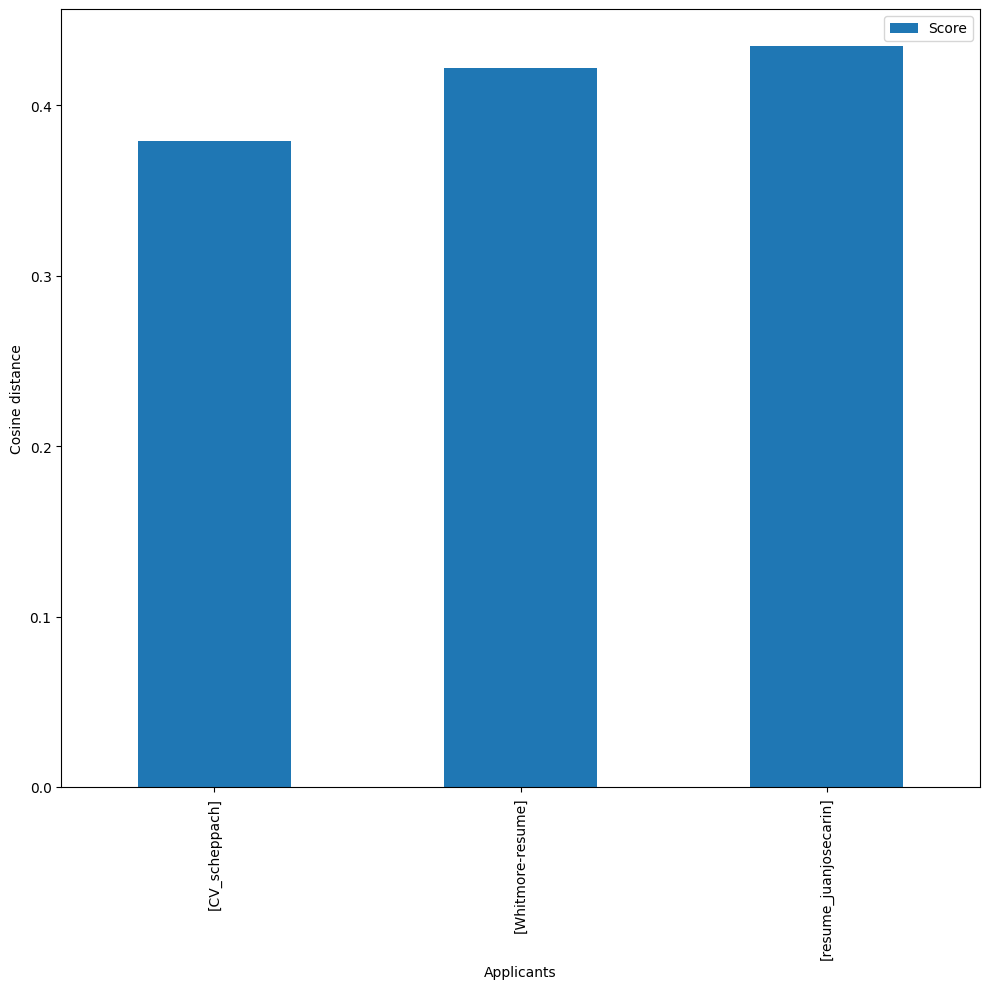

In [5]:
applicant_values = []
score_values = []
for doc in docs_score:
    applicant_values.append(doc[0].metadata["source"].split('\\')[-1].split('.')[0:-1])
    score_values.append(doc[1])

data = pd.DataFrame({'Applicant': applicant_values, 'Score': score_values})

fig, ax = plt.subplots(figsize=(10, 10))
data.plot.bar(x='Applicant', y='Score', ax=ax)
ax.set_xlabel('Applicants')
ax.set_ylabel('Cosine distance')
plt.tight_layout()
plt.show()

In summary: I calculated the distance between resumes and a job description, by converting the documents into their respective language embeddings. Then, I measure the similarity between the embeddings using the distance metric cosine similarity distance. The resulting distance score provides us with a quantitative measure of how closely the content of the resume aligns with the requirements outlined in the job description.